# Period analysis of Gaia DR3 objects in the QSO table

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../src')
from pathlib import Path
import polars as pl
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt

from preprocessing import preprocess_lc

plt.rc('font',   size=16)    
plt.rc('axes',   titlesize=14)
plt.rc('axes',   labelsize=14)
plt.rc('xtick',  labelsize=14)
plt.rc('ytick',  labelsize=14)
plt.rc('legend', fontsize=16)
plt.rc('figure', titlesize=16)
plt.rcParams['text.usetex'] = True

In [2]:
qso_selection = pl.read_parquet(
    '../data/gaia_qso_initial_selection.parquet', columns=['sourceid', 'time_duration_g_fov'],
).join(
    pl.read_parquet('../results/periods/'), 
    on='sourceid'
)
len(qso_selection)

770110

## Periods and false alarm probabilities of the initial selection

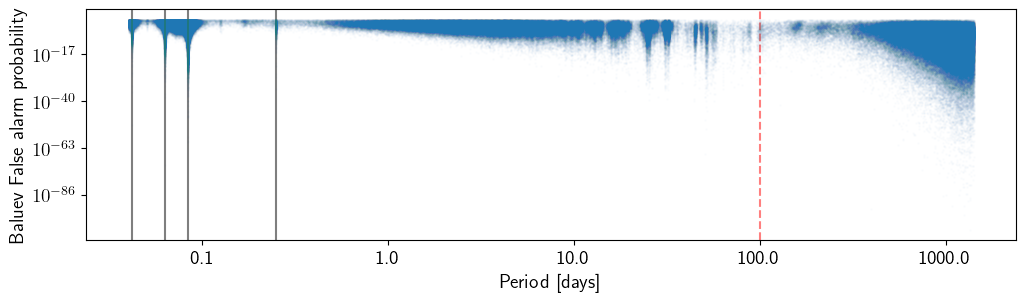

In [3]:
fig, ax = plt.subplots(figsize=(12, 3))
ax.set_xlabel('Period [days]')
ax.set_ylabel('Baluev False alarm probability');

plot_cols = ['NUFFT_frequency', 'FAP']
x, y = qso_selection.select(plot_cols).to_numpy().T
ax.scatter(-np.log10(x), y, s=1, alpha=0.01)

import matplotlib.ticker as ticker
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: f'{10**y}'))

for spurious_freq in [4, 12, 16, 24]:
    ax.axvline(-np.log10(spurious_freq), c='k', alpha=0.5, zorder=-100)
ax.axvline(np.log10(100), c='r', ls='--', alpha=0.5, zorder=-100)
ax.set_yscale('log')

Black lines are used to denote known spurious periodicities due to scan-angle effects

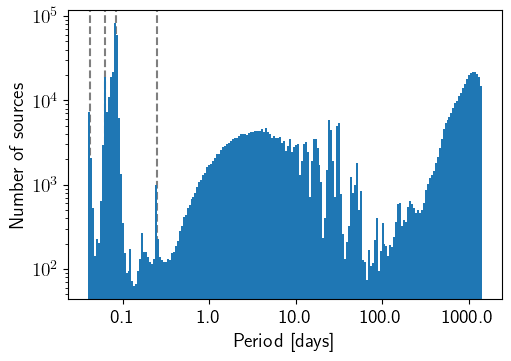

In [4]:
fig, ax = plt.subplots(figsize=(5, 3.5), constrained_layout=True)
ax.set_xlabel('Period [days]')
ax.set_ylabel('Number of sources')
plot_cols = 'NUFFT_frequency'
bins = 200
xrange = (np.log10(1/25), np.log10(1/0.0007))
ax.hist(
    qso_selection.select(plot_cols).to_series().log10()*-1, 
    bins=bins, alpha=1.0, density=False, range=xrange);

import matplotlib.ticker as ticker
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: f'{10**y}'))

for spurious_freq in [4, 12, 16, 24]:
    ax.axvline(-np.log10(spurious_freq), c='k', ls='--', alpha=0.5, zorder=-100)
ax.set_yscale('log')
plt.savefig('figures/periods1.pdf', dpi=300, bbox_inches='tight')

Percentage of sources with with FAP < threshold

In [5]:
for threshold in [0.01, 0.005, 0.001]:
    print(f"{threshold}: {100*len(qso_selection.filter(pl.col('FAP')<threshold))/len(qso_selection):0.4f}%")

0.01: 82.4835%
0.005: 78.3776%
0.001: 68.4570%


## Filtering the initial selection

The period has to be longer than a 100 days and at most 66% of the total time span of the light curve

In [6]:
period_filter = (1.0/pl.col('NUFFT_frequency') > 100) & (1.0/pl.col('NUFFT_frequency') < pl.col('time_duration_g_fov')/1.5) 
qso_period_filtered = qso_selection.filter(period_filter)

len(qso_period_filtered)

48472

The distribution of periods in this selection

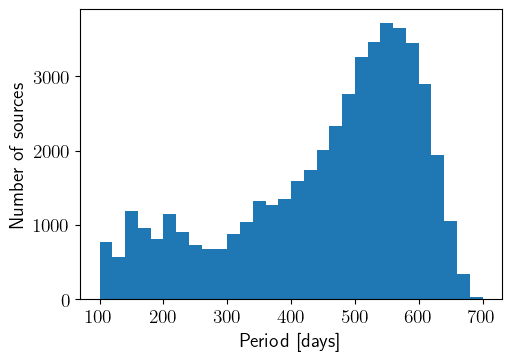

In [7]:
fig, ax = plt.subplots(figsize=(5, 3.5), constrained_layout=True)
ax.set_xlabel('Period [days]')
ax.set_ylabel('Number of sources')
bins = 40
xrange = (0, 800)
ax.hist(
    1/qso_period_filtered.select('NUFFT_frequency').to_series(), 
    bins=bins, alpha=1.0, density=False, range=xrange);

ax.set_xlim([70, 730])
plt.savefig('figures/periods2.pdf', dpi=300, bbox_inches='tight')

In [10]:
qso_period_filtered.write_parquet(f'../results/gaia_qso_period_gt100d.parquet')

Prepare parquets for MCMC

In [11]:
metadata = qso_period_filtered.with_columns(
    (1.0/pl.col('NUFFT_frequency')).alias('period')
).select(['sourceid', 'period'])

gaia_qso_period_gt100d_lc = []
for file in Path('../data/gaia_qso_initial_selection/').glob('*.parquet'):
    gaia_qso_period_gt100d_lc.append(pl.read_parquet(file).join(metadata, on='sourceid'))
    
gaia_qso_period_gt100d_lc = pl.concat(gaia_qso_period_gt100d_lc)

In [13]:
chunk_size = 2000
save_dir = Path('../data/gaia_qso_period_gt100d')
save_dir.mkdir(exist_ok=True)
for i in range(0, len(gaia_qso_period_gt100d_lc), chunk_size):
    gaia_qso_period_gt100d_lc.slice(i, chunk_size).write_parquet(save_dir / f"part_{i // chunk_size}.parquet", compression_level=21)